link github untuk AOL https://github.com/huyquoctrinh/MetaPolyp-CBMS2023.git

In [ ]:
!git clone https://github.com/huyquoctrinh/MetaPolyp-CBMS2023.git

Cloning into 'MetaPolyp-CBMS2023'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 99 (delta 48), reused 18 (delta 0), pack-reused 0
Receiving objects: 100% (99/99), 2.24 MiB | 6.30 MiB/s, done.
Resolving deltas: 100% (48/48), done.


In [ ]:
!pip install -U cython
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-fv_08chr
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-fv_08chr
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit dd070546eda51e21ab772ee6f14807c7f5b1548b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0-cp310-cp310-linux_x86_64.whl size=3405481 sha256=32e6a81079de44f83782675f2d567e0a8dcfd8d32081b422a9d3a3ed3b9d5193
  Stored in directory: /tmp/pip-ephem-wheel-cache-t7zyalua/wheels/01/5b/61/87443ed3bf03dd2940375cf2f8b6fba88efece935465e490b0
Successfully built pydensecrf


In [ ]:
!pip install -r /content/MetaPolyp-CBMS2023/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 738.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.5/572.5 kB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 45.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tensorflow-datasets to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy
import numpy as np

from keras.utils import get_custom_objects
import os
# from supervision.dataloader import build_augmenter, build_dataset, build_decoder
import os
import tensorflow_addons as tfa
import time
import cv2

from tqdm import tqdm

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

#Metrics

In [ ]:
def dice_coeff(y_true, y_pred):

    _epsilon = 10 ** -7
    intersections = tf.reduce_sum(y_true * y_pred)
    unions = tf.reduce_sum(y_true + y_pred)
    dice_scores = (2.0 * intersections + _epsilon) / (unions + _epsilon)

    return dice_scores

def dice_loss(y_true, y_pred):

    loss = 1 - dice_coeff(y_true, y_pred)

    return loss

def total_loss(y_true, y_pred):
    return 0.5*binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def IoU(y_true, y_pred, eps=1e-6):

    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection

    return K.mean( (intersection + eps) / (union + eps), axis=0)

def zero_IoU(y_true, y_pred):

    return IoU(1-y_true, 1-y_pred)

def bce_dice_loss(y_true, y_pred):

    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


#Util

In [ ]:
def default_augment_seg(input_image, input_mask):

    input_image = tf.image.random_brightness(input_image, 0.1)
    input_image = tf.image.random_contrast(input_image, 0.9, 1.1)
    input_image = tf.image.random_saturation(input_image, 0.9, 1.1)
    input_image = tf.image.random_hue(input_image, 0.01)

    # flipping random horizontal or vertical
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_up_down(input_image)
        input_mask = tf.image.flip_up_down(input_mask)

    return input_image, input_mask

def BatchAdvAugmentSeg(imagesT, masksT):

    images, masks = default_augment_seg(imagesT, masksT)

    return images, masks

def build_decoder(with_labels=True, target_size=(256, 256), ext='png', segment=False, ext2='png'):

    def decode(path):
        file_bytes = tf.io.read_file(path)
        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels=3, dct_method='INTEGER_ACCURATE')
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels=3, dct_method='INTEGER_ACCURATE')
        else:
            raise ValueError("Image extension not supported")

        img = tf.image.resize(img, target_size)
        # img = tf.cast(img, tf.float32) / 255.0

        return img

    def decode_mask(path, gray=True):
        file_bytes = tf.io.read_file(path)
        if ext2 == 'png':
            img = tf.image.decode_png(file_bytes, channels=3)
        elif ext2 in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels=3)
        else:
            raise ValueError("Image extension not supported")

        img = tf.image.rgb_to_grayscale(img) if gray else img
        img = tf.image.resize(img, target_size)
        img = tf.cast(img, tf.float32) / 255.0

        return img

    def decode_with_labels(path, label):
        return decode(path), label

    def decode_with_segments(path, path2, gray=True):
        return decode(path), decode_mask(path2, gray)

    if segment:
        return decode_with_segments

    return decode_with_labels if with_labels else decode


def build_augmenter(with_labels=True):
    def augment(img):

        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_flip_left_right(img)
#         img = tf.image.rot90(img, k=tf.random.uniform([],0,4,tf.int32))

        img = tf.image.random_brightness(img, 0.1)
        img = tf.image.random_contrast(img, 0.9, 1.1)
        img = tf.image.random_saturation(img, 0.9, 1.1)
        img = tf.image.random_hue(img, 0.02)

        # img = transform_mat(img)

        return img

    def augment_with_labels(img, label):
        return augment(img), label

    return augment_with_labels if with_labels else augment


def build_dataset(paths, labels=None, bsize=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, augmentAdv=False, augmentAdvSeg=False, repeat=True, shuffle=1024,
                  cache_dir=""):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)

    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)

    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)

    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)

    dset = tf.data.Dataset.from_tensor_slices(slices)
    dset = dset.map(decode_fn, num_parallel_calls=AUTO)
    dset = dset.cache(cache_dir) if cache else dset
    dset = dset.map(augment_fn, num_parallel_calls=AUTO) if augment else dset
    #dset = dset.repeat() if repeat else dset
    dset = dset.shuffle(shuffle) if shuffle else dset
    dset = dset.batch(bsize)
    # dset = dset.map(BatchAdvAugment, num_parallel_calls=AUTO) if augmentAdv else dset
    dset = dset.map(BatchAdvAugmentSeg, num_parallel_calls=AUTO) if augmentAdvSeg else dset
    dset = dset.prefetch(AUTO)

    return dset

#*layers*

In [ ]:
#upsampling
from keras.layers import Conv2D

def bn_act(inputs, activation='swish'):

    x = tf.keras.layers.BatchNormalization()(inputs)
    if activation:
        x = tf.keras.layers.Activation(activation)(x)

    return x

def decode(input_tensor, filters, scale = 2, activation = 'relu'):

    x1 = tf.keras.layers.Conv2D(filters, (1, 1), activation=activation, use_bias=False,
                                kernel_initializer='he_normal', padding = 'same')(input_tensor)

    x2 = tf.keras.layers.Conv2D(filters, (3, 3), activation=activation,
                                use_bias=False, padding = 'same')(input_tensor)

    merge = tf.keras.layers.Add()([x1, x2])
    x = tf.keras.layers.UpSampling2D((scale, scale))(merge)

    skip_feature = tf.keras.layers.Conv2D(filters, (3, 3), activation=activation, use_bias=False,
                                        kernel_initializer='he_normal', padding = 'same')(merge)

    skip_feature = tf.keras.layers.Conv2D(filters, (1, 1), activation=activation, use_bias=False,
                                        kernel_initializer='he_normal', padding = 'same')(skip_feature)

    merge = tf.keras.layers.Add()([merge, skip_feature])

    x = bn_act(x, activation = activation)


    return x

In [ ]:
#util_layer
def conv_bn_act(inputs, filters, kernel_size, strides=(1, 1), activation='relu', padding='same'):

    x = Conv2D(filters, kernel_size=kernel_size, padding=padding)(inputs)
    x = bn_act(x, activation=activation)

    return x

def merge(l, filters=None):
    if filters is None:
        channel_axis = 1 if K.image_data_format() == "channels_first" else -1
        filters = l[0].shape[channel_axis]

    x = tf.keras.layers.Add()([l[0],l[1]])

    # x = block(x, filters)

    return x

In [ ]:
#convformer
def convformer(input_tensor, filters, padding = "same"):

    x = tf.keras.layers.LayerNormalization()(input_tensor)
    x = tf.keras.layers.SeparableConv2D(filters, kernel_size = (3,3), padding = padding)(x)
    # x = x1 + x2 + x3
    x = tf.keras.layers.Attention()([x, x, x])
    out = tf.keras.layers.Add()([x, input_tensor])

    x1 = tf.keras.layers.Dense(filters, activation = "gelu")(out)
    x1 = tf.keras.layers.Dense(filters)(x1)
    out_tensor = tf.keras.layers.Add()([out, x1])
    return out_tensor

#Model

In [ ]:
from keras_cv_attention_models import caformer
from keras.models import Model
from keras.layers import Conv2D

def build_model(img_size = 256, num_classes = 1):
    backbone = caformer.CAFormerS18(input_shape=(256, 256, 3), pretrained="imagenet", num_classes = 0)

    layer_names = ['stack4_block3_mlp_Dense_1', 'stack3_block9_mlp_Dense_1', 'stack2_block3_mlp_Dense_1', 'stack1_block3_mlp_Dense_1']
    layers = [backbone.get_layer(x).output for x in layer_names]

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    h_axis, w_axis = [2, 3] if K.image_data_format() == "channels_first" else [1, 2]

    x = layers[0]

    upscale_feature = decode(x, scale = 4, filters = x.shape[channel_axis])

    for i, layer in enumerate(layers[1:]):

        x = decode(x, scale = 2, filters = layer.shape[channel_axis])

        layer_fusion = convformer(layer, layer.shape[channel_axis])

        ## Doing multi-level concatenation
        if (i%2 == 1):
            upscale_feature = tf.keras.layers.Conv2D(layer.shape[channel_axis], (1, 1), activation = "relu", padding = "same")(upscale_feature)
            x = tf.keras.layers.Add()([x, upscale_feature])
            x = tf.keras.layers.Conv2D(x.shape[channel_axis], (1, 1), activation = "relu", padding = "same")(x)

        x = merge([x, layer_fusion], layer.shape[channel_axis])
        x = conv_bn_act(x, layer.shape[channel_axis], (1, 1))

        ## Upscale for next level feature
        if (i%2 == 1):
            upscale_feature = decode(x, scale = 8, filters = layer.shape[channel_axis])

    filters = x.shape[channel_axis] //2
    upscale_feature = conv_bn_act(upscale_feature, filters, 1)
    x = decode(x, filters, 4)
    x = tf.keras.layers.Add()([x, upscale_feature])
    x = conv_bn_act(x, filters, 1)
    x = Conv2D(num_classes, kernel_size=1, padding='same', activation='sigmoid')(x)
    model = Model(backbone.input, x)

    return model

#callbacks

In [ ]:
import math
import tensorflow as tf
import matplotlib.pyplot as plt

def cosine_annealing_with_warmup(epochIdx):
    aMax, aMin = max_lr, min_lr
    warmupEpochs, stagnateEpochs, cosAnnealingEpochs = 0, 0, cos_anne_ep
    epochIdx = epochIdx % (warmupEpochs + stagnateEpochs + cosAnnealingEpochs)
    if(epochIdx < warmupEpochs):
        return aMin + (aMax - aMin) / (warmupEpochs - 1) * epochIdx
    else:
        epochIdx -= warmupEpochs
    if(epochIdx < stagnateEpochs):
        return aMax
    else:
        epochIdx -= stagnateEpochs
    return aMin + 0.5 * (aMax - aMin) * (1 + math.cos((epochIdx + 1) / (cosAnnealingEpochs + 1) * math.pi))

def plt_lr(step, schedulers):
    x = range(step)
    y = [schedulers(_) for _ in x]

    plt.plot(x, y)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()

def get_callbacks(monitor, mode, save_path, _max_lr, _min_lr, _cos_anne_ep, save_weights_only):
    global max_lr
    max_lr = _max_lr
    global min_lr
    min_lr = _min_lr
    global cos_anne_ep
    cos_anne_ep = _cos_anne_ep

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor=monitor,
        patience=60,
        restore_best_weights=True,
        mode=mode
    )

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor=monitor,
        factor=0.2,
        patience=30,
        verbose=1,
        mode=mode,
        min_lr=1e-5,
    )

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=save_path,
        monitor=monitor,
        verbose=1,
        save_best_only=True,
        save_weights_only=save_weights_only,
        mode=mode,
        save_freq="epoch",
    )

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(cosine_annealing_with_warmup, verbose=0)

    csv_logger = tf.keras.callbacks.CSVLogger('training.csv')

    callbacks = [checkpoint, csv_logger, reduce_lr]
# , reduce_lr
    return callbacks

#Parameter

In [ ]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [ ]:
#parameter
img_size = 256
BATCH_SIZE = 16
SEED = 42
save_path = "best_model.h5"

In [ ]:
valid_size = 0.1
test_size = 0.1
epochs = 350
save_weights_only = True
max_lr = 1e-4
min_lr = 1e-6

decay_steps = 1000

In [ ]:
def myprint(s):
    with open('modelsummary.txt','a') as f:
        print(s, file=f)

In [ ]:
model = build_model(img_size)

>>>> Load pretrained from: /root/.keras/models/caformer_s18_224_imagenet.h5


In [ ]:
model.summary(print_fn=myprint)

In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_ (ZeroPadding2D)          (None, 260, 260, 3)  0           ['input_6[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 64, 64, 64)   9472        ['stem_[0][0]']                  
                                                                                                  
 stem_ln (LayerNormalization)   (None, 64, 64, 64)   64          ['stem_conv[0][0]']        

In [ ]:
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    max_lr,
    decay_steps,
    min_lr,
    power=0.2)

In [ ]:
opts = tfa.optimizers.AdamW(learning_rate = 1e-4, weight_decay = learning_rate_fn)

In [ ]:
get_custom_objects().update({"dice": dice_loss})

#Dataset

In [ ]:
import gdown
url = 'https://drive.google.com/drive/folders/1btVK5NUVFVew4oZ8RGgu0No0jAHivenl'
gdown.download_folder(url)
!unzip Kvasir-SEG/kvasir-seg.zip

Retrieving folder list


Processing file 1GtJGmfd-2d5eAFzhpa3Hp2FY_ccurpAS kvasir-seg.zip
Processing file 1VO3kohakS_ldOsghnktO5L-6iikwUh1K metadata.csv
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1GtJGmfd-2d5eAFzhpa3Hp2FY_ccurpAS
To: /content/Kvasir-SEG/kvasir-seg.zip
100%|██████████| 46.2M/46.2M [00:00<00:00, 61.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1VO3kohakS_ldOsghnktO5L-6iikwUh1K
To: /content/Kvasir-SEG/metadata.csv
0.00B [00:00, ?B/s]
Download completed


Archive:  Kvasir-SEG/kvasir-seg.zip
  inflating: Kvasir-SEG/kavsir_bboxes.json  
   creating: Kvasir-SEG/images/
  inflating: Kvasir-SEG/images/ck2bxiswtxuw80838qkisqjwz.jpg  
  inflating: Kvasir-SEG/images/ck2bxknhjvs1x0794iogrq49k.jpg  
  inflating: Kvasir-SEG/images/ck2bxlujamu330725szlc2jdu.jpg  
  inflating: Kvasir-SEG/images/ck2bxpfgxu2mk0748gsh7xelu.jpg  
  inflating: Kvasir-SEG/images/ck2bxqz3evvg20794iiyv5v2m.jpg  
  inflating: Kvasir-SEG/images/ck2bxskgxxzfv08386xkqtqdy.jpg  
  inflating: Kvasir-SEG/images/ck2bxw18mmz1k0725litqq2mc.jpg  
  inflating: Kvasir-SEG/images/ck2395w2mb4vu07480otsu6tw.jpg  
  inflating: Kvasir-SEG/images/ck2da7fwcjfis07218r1rvm95.jpg  
  inflating: Kvasir-SEG/images/cjyzjzssvd8pq0838f4nolj5l.jpg  
  inflating: Kvasir-SEG/images/cjyzk8qieoboa0848ogj51wwm.jpg  
  inflating: Kvasir-SEG/images/cju5hi52odyf90817prvcwg45.jpg  
  inflating: Kvasir-SEG/images/cju5hjxaae3i40850h5z2laf5.jpg  
  inflating: Kvasir-SEG/images/cju5hl8nee8a40755fm8qjj0o.jpg  
  inf

In [ ]:
route = '/content/Kvasir-SEG'
X_path = '/content/Kvasir-SEG/images/'
Y_path = '/content/Kvasir-SEG/masks/'

In [ ]:
X_full = sorted(os.listdir(f'{route}/images'))
Y_full = sorted(os.listdir(f'{route}/masks'))

In [ ]:
X_train, X_valid = train_test_split(X_full, test_size=0.2, random_state=SEED)
Y_train, Y_valid = train_test_split(Y_full, test_size=0.2, random_state=SEED)

X_valid, X_test = train_test_split(X_valid, test_size=0.5, random_state=SEED)
Y_valid, Y_test = train_test_split(Y_valid, test_size=0.5, random_state=SEED)

In [ ]:
X_train = [X_path + x for x in X_train]
X_valid = [X_path + x for x in X_valid]
X_test = [X_path + x for x in X_test]

Y_train = [Y_path + x for x in Y_train]
Y_valid = [Y_path + x for x in Y_valid]
Y_test = [Y_path + x for x in Y_test]

In [ ]:
print("N Train:", len(X_train))
print("N Valid:", len(X_valid))
print("N test:", len(X_test))

N Train: 800
N Valid: 100
N test: 100


In [ ]:
train_decoder = build_decoder(with_labels=True, target_size=(img_size, img_size), ext='jpg', segment=True, ext2='jpg')
train_dataset = build_dataset(X_train, Y_train, bsize=BATCH_SIZE, decode_fn=train_decoder,
                            augmentAdv=True, augment=True, augmentAdvSeg=True)


valid_decoder = build_decoder(with_labels=True, target_size=(img_size, img_size), ext='jpg', segment=True, ext2='jpg')
valid_dataset = build_dataset(X_valid, Y_valid, bsize=BATCH_SIZE, decode_fn=valid_decoder,
                            augmentAdv=False, augment=False, repeat=False, shuffle=False,
                            augmentAdvSeg=False)


test_decoder = build_decoder(with_labels=True, target_size=(img_size, img_size), ext='jpg', segment=True, ext2='jpg')
test_dataset = build_dataset(X_test, Y_test, bsize=BATCH_SIZE, decode_fn=test_decoder,
                            augmentAdv=False, augment=False, repeat=False, shuffle=False,
                            augmentAdvSeg=False)

In [ ]:
steps_per_epoch = len(X_train) // BATCH_SIZE

In [ ]:
print(train_dataset)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>


#Trainning

In [ ]:
callbacks = get_callbacks(monitor = 'val_IoU', mode = 'max', save_path = save_path, _max_lr = max_lr
                        , _min_lr = min_lr , _cos_anne_ep = 1000, save_weights_only = save_weights_only)

In [ ]:
model = build_model(img_size)

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


106298480/106298480 [==============================] - 1s 0us/step
>>>> Load pretrained from: /root/.keras/models/caformer_s18_224_imagenet.h5


In [ ]:
model.compile(optimizer = opts,
            loss='dice',
            metrics=["acc", dice_coeff, IoU, bce_dice_loss])

In [ ]:
start_time = time.time()
his = model.fit(train_dataset,
            epochs=150,
            callbacks=callbacks,
            steps_per_epoch=steps_per_epoch,
            validation_data=valid_dataset)
MetaPloyp_computational = time.time()-start_time

Epoch 1/150
50/50 [==============================] - ETA: 0s - loss: 0.6475 - acc: 0.5502 - dice_coeff: 0.3525 - IoU: 0.2075 - bce_dice_loss: 1.5472
Epoch 1: val_IoU improved from -inf to 0.31023, saving model to best_model.h5
50/50 [==============================] - 72s 786ms/step - loss: 0.6475 - acc: 0.5502 - dice_coeff: 0.3525 - IoU: 0.2075 - bce_dice_loss: 1.5472 - val_loss: 0.4758 - val_acc: 0.8415 - val_dice_coeff: 0.5145 - val_IoU: 0.3102 - val_bce_dice_loss: 1.5815 - lr: 1.0000e-04
Epoch 2/150
50/50 [==============================] - ETA: 0s - loss: 0.5056 - acc: 0.8351 - dice_coeff: 0.4944 - IoU: 0.3043 - bce_dice_loss: 1.0844
Epoch 2: val_IoU improved from 0.31023 to 0.54624, saving model to best_model.h5
50/50 [==============================] - 34s 677ms/step - loss: 0.5056 - acc: 0.8351 - dice_coeff: 0.4944 - IoU: 0.3043 - bce_dice_loss: 1.0844 - val_loss: 0.2658 - val_acc: 0.9201 - val_dice_coeff: 0.7387 - val_IoU: 0.5462 - val_bce_dice_loss: 0.8730 - lr: 1.0000e-04
Epoch

In [ ]:
hist_dict = his.history

train_loss = hist_dict["loss"]
val_loss = hist_dict["val_loss"]

train_iou = hist_dict["IoU"]
val_iou = hist_dict["val_IoU"]

## Get number of epochs
epochs = range(1, len(train_loss)+1)

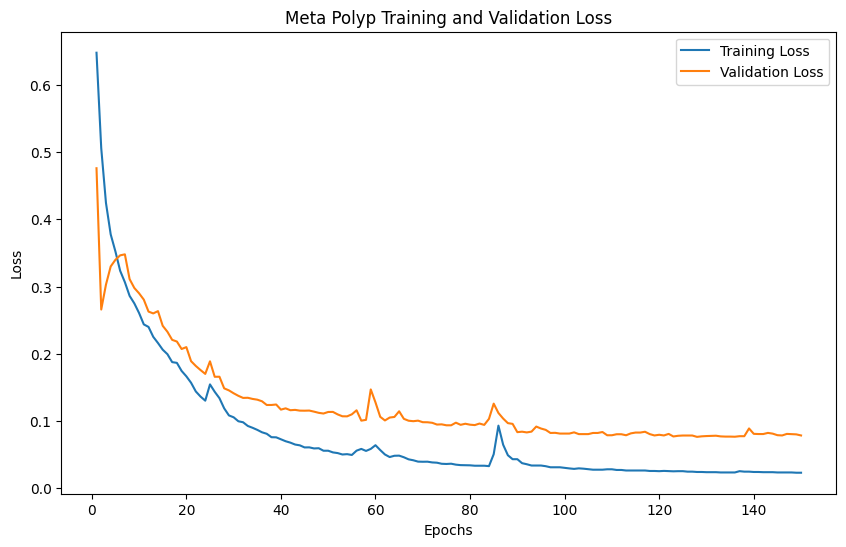

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, val_loss, label = "Validation Loss")
plt.title('Meta Polyp Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

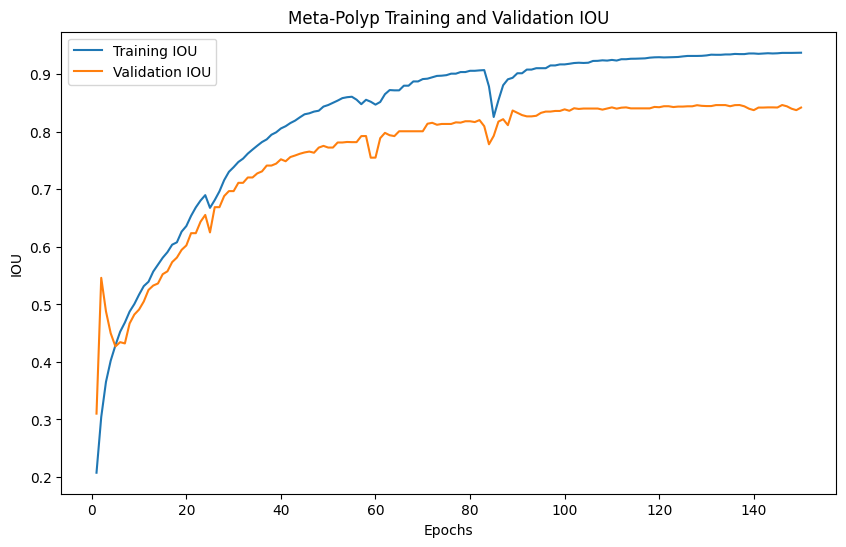

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(epochs, train_iou, label="Training IOU")
plt.plot(epochs, val_iou, label = "Validation IOU")
plt.title('Meta-Polyp Training and Validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()

#Test Time Augmentation (TTA) and CRF


In [ ]:
import numpy as np

def horizontal_flip(image):
    image = image[:, ::-1, :]
    return image

def vertical_flip(image):
    image = image[::-1, :, :]
    return image

def tta_model(model, image):
    n_image = image
    h_image = horizontal_flip(image)
    v_image = vertical_flip(image)

    n_mask = model.predict(np.expand_dims(n_image, axis=0))[0]
    h_mask = model.predict(np.expand_dims(h_image, axis=0))[0]
    v_mask = model.predict(np.expand_dims(v_image, axis=0))[0]

    n_mask = n_mask
    h_mask = horizontal_flip(h_mask)
    v_mask = vertical_flip(v_mask)

    mean_mask = (n_mask + h_mask + v_mask) / 3.0
    return mean_mask

In [ ]:
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral

def apply_crf(ori_image, mask):
    """ Conditional Random Field
    ori_image: np.array with value between 0-255
    mask: np.array with value between 0-1
    """

    ## Grayscale to RGB
    # if len(mask.shape) < 3:
    #     mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

    ## Converting the anotations RGB to single 32  bit color
    annotated_label = mask.astype(np.int32)
    # annotated_label = mask[:,:,0] + (mask[:,:,1]<<8) + (mask[:,:,2]<<16)

    ## Convert the 32bit integer color to 0,1, 2, ... labels.
    colors, labels = np.unique(annotated_label, return_inverse=True)
    n_labels = 2

    ## Setting up the CRF model
    d = dcrf.DenseCRF2D(ori_image.shape[1], ori_image.shape[0], n_labels)

    ## Get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)

    ## This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    ## Run Inference for 10 steps
    Q = d.inference(10)

    ## Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((ori_image.shape[0], ori_image.shape[1]))

#fucntion evaluation

In [ ]:
test_steps = (len(X_test)//16)

if len(X_test) % 16 != 0:
  test_steps += 1

In [ ]:
model = build_model(img_size)
model.load_weights('/content/best_model.h5')

model.compile(optimizer = opts,
            loss='dice',
            metrics=["acc", dice_coeff, IoU, bce_dice_loss])

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


>>>> Load pretrained from: /root/.keras/models/caformer_s18_224_imagenet.h5


#evaluate function

In [ ]:
smooth=0.1

In [ ]:
def read_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (256, 256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x = np.expand_dims(img, axis=0)
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

In [ ]:
def get_dice_coef(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def IoU(y_true, y_pred, eps=1e-6):
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.int32)
    y_true = y_true.astype(np.int32)
    m = tf.keras.metrics.MeanIoU(num_classes=2)
    m.update_state(y_true, y_pred)
    r = m.result().numpy()
    m.reset_states()
    return r


In [ ]:
def acc(y_true, y_pred):
  y_pred = y_pred > 0.5
  y_pred = y_pred.astype(np.int32)
  m = tf.keras.metrics.Accuracy()
  m.update_state(y_true, y_pred)
  r = m.result().numpy()
  m.reset_states()
  return r

In [ ]:
def get_metrics(y_true, y_pred):
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()

    dice_coef_val = dice_coeff(y_true, y_pred)
    mean_iou_val = IoU(y_true, y_pred)

    y_true = y_true.astype(np.int32)
    # recall_value = recall_score(y_pred, y_true, average='micro')
    # precision_value = precision_score(y_pred, y_true, average='micro')

    accuracy_val = acc(y_true, y_pred)

    return [dice_coef_val, mean_iou_val, accuracy_val]

In [ ]:
def evaluate_normal(model, x_data, y_data):
    total = []
    for x, y in tqdm(zip(x_data, y_data), total=len(x_data)):
        x = read_image(x)
        y = read_mask(y)
        y_pred = model.predict(x)[0] > 0.5
        y_pred = y_pred.astype(np.float32)

        value = get_metrics(y, y_pred)
        total.append(value)

    mean_value = np.mean(total, axis=0)
    print(mean_value)

In [ ]:
def evaluate_tta(model, x_data, y_data):
    total = []
    for x, y in tqdm(zip(x_data, y_data), total=len(x_data)):
        x = read_image(x)
        y = read_mask(y)
        y_pred = tta_model(model, x[0])
        y_pred = y_pred > 0.5
        y_pred = y_pred.astype(np.float32)

        value = get_metrics(y, y_pred)
        total.append(value)

    mean_value = np.mean(total, axis=0)
    print(mean_value)

In [ ]:
def evaluate_crf(model, x_data, y_data):
    total = []
    for x, y in tqdm(zip(x_data, y_data), total=len(x_data)):
        x = read_image(x)
        y = read_mask(y)
        y_pred = model.predict(x)[0] > 0.5
        y_pred = y_pred.astype(np.float32)
        y_pred = apply_crf(x[0]*255, y_pred)

        value = get_metrics(y, y_pred)
        total.append(value)

    mean_value = np.mean(total, axis=0)
    print(mean_value)

In [ ]:
def evaluate_crf_tta(model, x_data, y_data):
    total = []
    for x, y in tqdm(zip(x_data, y_data), total=len(x_data)):
        x = read_image(x)
        y = read_mask(y)
        y_pred = tta_model(model, x[0])
        y_pred = y_pred > 0.5
        y_pred = y_pred.astype(np.float32)
        y_pred = apply_crf(x[0]*255, y_pred)

        value = get_metrics(y, y_pred)
        total.append(value)

    mean_value = np.mean(total, axis=0)
    print(mean_value)

#evaluate

In [ ]:
start_time = time.time()
evaluate_normal(model, X_test, Y_test)
Segmentation_Time = time.time()-start_time

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 70ms/step


  1%|          | 1/100 [00:00<00:14,  6.69it/s]

1/1 [==============================] - 0s 69ms/step


  2%|▏         | 2/100 [00:00<00:13,  7.06it/s]

1/1 [==============================] - 0s 71ms/step


  3%|▎         | 3/100 [00:00<00:13,  7.11it/s]

1/1 [==============================] - 0s 69ms/step


  4%|▍         | 4/100 [00:00<00:13,  7.23it/s]

1/1 [==============================] - 0s 73ms/step


  5%|▌         | 5/100 [00:00<00:13,  7.18it/s]

1/1 [==============================] - 0s 71ms/step


  6%|▌         | 6/100 [00:00<00:13,  7.19it/s]

1/1 [==============================] - 0s 109ms/step


  7%|▋         | 7/100 [00:01<00:15,  5.85it/s]

1/1 [==============================] - 0s 101ms/step


  8%|▊         | 8/100 [00:01<00:16,  5.58it/s]

1/1 [==============================] - 0s 96ms/step


  9%|▉         | 9/100 [00:01<00:16,  5.50it/s]

1/1 [==============================] - 0s 95ms/step


 10%|█         | 10/100 [00:01<00:16,  5.38it/s]

1/1 [==============================] - 0s 100ms/step


 11%|█         | 11/100 [00:01<00:16,  5.26it/s]

1/1 [==============================] - 0s 96ms/step


 12%|█▏        | 12/100 [00:02<00:16,  5.32it/s]

1/1 [==============================] - 0s 91ms/step


 13%|█▎        | 13/100 [00:02<00:16,  5.40it/s]

1/1 [==============================] - 0s 112ms/step


 14%|█▍        | 14/100 [00:02<00:16,  5.22it/s]

1/1 [==============================] - 0s 101ms/step


 15%|█▌        | 15/100 [00:02<00:16,  5.16it/s]

1/1 [==============================] - 0s 95ms/step


 16%|█▌        | 16/100 [00:02<00:16,  4.99it/s]

1/1 [==============================] - 0s 97ms/step


 17%|█▋        | 17/100 [00:03<00:16,  5.10it/s]

1/1 [==============================] - 0s 95ms/step


 18%|█▊        | 18/100 [00:03<00:16,  5.12it/s]

1/1 [==============================] - 0s 95ms/step


 19%|█▉        | 19/100 [00:03<00:16,  5.00it/s]

1/1 [==============================] - 0s 97ms/step


 20%|██        | 20/100 [00:03<00:15,  5.10it/s]

1/1 [==============================] - 0s 102ms/step


 21%|██        | 21/100 [00:03<00:15,  5.09it/s]

1/1 [==============================] - 0s 96ms/step


 22%|██▏       | 22/100 [00:03<00:15,  5.19it/s]

1/1 [==============================] - 0s 99ms/step


 23%|██▎       | 23/100 [00:04<00:16,  4.71it/s]

1/1 [==============================] - 0s 101ms/step


 24%|██▍       | 24/100 [00:04<00:15,  4.87it/s]

1/1 [==============================] - 0s 62ms/step


 25%|██▌       | 25/100 [00:04<00:14,  5.33it/s]

1/1 [==============================] - 0s 62ms/step


 26%|██▌       | 26/100 [00:04<00:12,  5.88it/s]

1/1 [==============================] - 0s 69ms/step


 27%|██▋       | 27/100 [00:04<00:11,  6.20it/s]

1/1 [==============================] - 0s 64ms/step


 28%|██▊       | 28/100 [00:04<00:10,  6.56it/s]

1/1 [==============================] - 0s 71ms/step


 29%|██▉       | 29/100 [00:05<00:10,  6.76it/s]

1/1 [==============================] - 0s 66ms/step


 30%|███       | 30/100 [00:05<00:10,  6.95it/s]

1/1 [==============================] - 0s 67ms/step


 31%|███       | 31/100 [00:05<00:09,  7.01it/s]

1/1 [==============================] - 0s 71ms/step


 32%|███▏      | 32/100 [00:05<00:09,  7.02it/s]

1/1 [==============================] - 0s 65ms/step


 33%|███▎      | 33/100 [00:05<00:09,  7.19it/s]

1/1 [==============================] - 0s 76ms/step


 34%|███▍      | 34/100 [00:05<00:10,  6.12it/s]

1/1 [==============================] - 0s 66ms/step


 35%|███▌      | 35/100 [00:06<00:10,  6.48it/s]

1/1 [==============================] - 0s 71ms/step


 36%|███▌      | 36/100 [00:06<00:09,  6.68it/s]

1/1 [==============================] - 0s 70ms/step


 37%|███▋      | 37/100 [00:06<00:09,  6.81it/s]

1/1 [==============================] - 0s 68ms/step


 38%|███▊      | 38/100 [00:06<00:08,  6.98it/s]

1/1 [==============================] - 0s 66ms/step


 39%|███▉      | 39/100 [00:06<00:08,  6.97it/s]

1/1 [==============================] - 0s 66ms/step


 40%|████      | 40/100 [00:06<00:08,  7.10it/s]

1/1 [==============================] - 0s 76ms/step


 41%|████      | 41/100 [00:06<00:09,  6.07it/s]

1/1 [==============================] - 0s 71ms/step


 42%|████▏     | 42/100 [00:07<00:09,  6.34it/s]

1/1 [==============================] - 0s 70ms/step


 43%|████▎     | 43/100 [00:07<00:08,  6.50it/s]

1/1 [==============================] - 0s 65ms/step


 44%|████▍     | 44/100 [00:07<00:08,  6.65it/s]

1/1 [==============================] - 0s 69ms/step


 45%|████▌     | 45/100 [00:07<00:08,  6.76it/s]

1/1 [==============================] - 0s 70ms/step


 46%|████▌     | 46/100 [00:07<00:07,  6.78it/s]

1/1 [==============================] - 0s 64ms/step


 47%|████▋     | 47/100 [00:07<00:07,  6.77it/s]

1/1 [==============================] - 0s 68ms/step


 48%|████▊     | 48/100 [00:07<00:07,  6.84it/s]

1/1 [==============================] - 0s 75ms/step


 49%|████▉     | 49/100 [00:08<00:07,  6.85it/s]

1/1 [==============================] - 0s 64ms/step


 50%|█████     | 50/100 [00:08<00:07,  6.98it/s]

1/1 [==============================] - 0s 67ms/step


 51%|█████     | 51/100 [00:08<00:06,  7.00it/s]

1/1 [==============================] - 0s 68ms/step


 52%|█████▏    | 52/100 [00:08<00:06,  7.07it/s]

1/1 [==============================] - 0s 63ms/step


 53%|█████▎    | 53/100 [00:08<00:06,  7.08it/s]

1/1 [==============================] - 0s 65ms/step


 54%|█████▍    | 54/100 [00:08<00:06,  7.07it/s]

1/1 [==============================] - 0s 67ms/step


 55%|█████▌    | 55/100 [00:08<00:06,  6.87it/s]

1/1 [==============================] - 0s 66ms/step


 56%|█████▌    | 56/100 [00:09<00:06,  7.00it/s]

1/1 [==============================] - 0s 68ms/step


 57%|█████▋    | 57/100 [00:09<00:06,  7.07it/s]

1/1 [==============================] - 0s 65ms/step


 58%|█████▊    | 58/100 [00:09<00:05,  7.21it/s]

1/1 [==============================] - 0s 65ms/step


 59%|█████▉    | 59/100 [00:09<00:05,  7.28it/s]

1/1 [==============================] - 0s 66ms/step


 60%|██████    | 60/100 [00:09<00:05,  7.24it/s]

1/1 [==============================] - 0s 64ms/step


 61%|██████    | 61/100 [00:09<00:05,  7.34it/s]

1/1 [==============================] - 0s 78ms/step


 62%|██████▏   | 62/100 [00:09<00:05,  7.03it/s]

1/1 [==============================] - 0s 71ms/step


 63%|██████▎   | 63/100 [00:10<00:05,  7.03it/s]

1/1 [==============================] - 0s 70ms/step


 64%|██████▍   | 64/100 [00:10<00:05,  7.03it/s]

1/1 [==============================] - 0s 69ms/step


 65%|██████▌   | 65/100 [00:10<00:05,  6.85it/s]

1/1 [==============================] - 0s 73ms/step


 66%|██████▌   | 66/100 [00:10<00:04,  6.87it/s]

1/1 [==============================] - 0s 68ms/step


 67%|██████▋   | 67/100 [00:10<00:04,  6.95it/s]

1/1 [==============================] - 0s 70ms/step


 68%|██████▊   | 68/100 [00:10<00:04,  7.01it/s]

1/1 [==============================] - 0s 76ms/step


 69%|██████▉   | 69/100 [00:11<00:05,  5.93it/s]

1/1 [==============================] - 0s 66ms/step


 70%|███████   | 70/100 [00:11<00:04,  6.22it/s]

1/1 [==============================] - 0s 72ms/step


 71%|███████   | 71/100 [00:11<00:04,  6.43it/s]

1/1 [==============================] - 0s 65ms/step


 72%|███████▏  | 72/100 [00:11<00:04,  6.65it/s]

1/1 [==============================] - 0s 73ms/step


 73%|███████▎  | 73/100 [00:11<00:04,  5.83it/s]

1/1 [==============================] - 0s 67ms/step


 74%|███████▍  | 74/100 [00:11<00:04,  6.23it/s]

1/1 [==============================] - 0s 68ms/step


 75%|███████▌  | 75/100 [00:11<00:03,  6.48it/s]

1/1 [==============================] - 0s 70ms/step


 76%|███████▌  | 76/100 [00:12<00:03,  6.66it/s]

1/1 [==============================] - 0s 76ms/step


 77%|███████▋  | 77/100 [00:12<00:03,  6.69it/s]

1/1 [==============================] - 0s 70ms/step


 78%|███████▊  | 78/100 [00:12<00:03,  6.79it/s]

1/1 [==============================] - 0s 67ms/step


 79%|███████▉  | 79/100 [00:12<00:03,  6.87it/s]

1/1 [==============================] - 0s 74ms/step


 80%|████████  | 80/100 [00:12<00:03,  5.92it/s]

1/1 [==============================] - 0s 64ms/step


 81%|████████  | 81/100 [00:12<00:03,  6.27it/s]

1/1 [==============================] - 0s 73ms/step


 82%|████████▏ | 82/100 [00:13<00:02,  6.52it/s]

1/1 [==============================] - 0s 67ms/step


 83%|████████▎ | 83/100 [00:13<00:02,  6.78it/s]

1/1 [==============================] - 0s 67ms/step


 84%|████████▍ | 84/100 [00:13<00:02,  6.72it/s]

1/1 [==============================] - 0s 73ms/step


 85%|████████▌ | 85/100 [00:13<00:02,  6.82it/s]

1/1 [==============================] - 0s 67ms/step


 86%|████████▌ | 86/100 [00:13<00:02,  6.89it/s]

1/1 [==============================] - 0s 71ms/step


 87%|████████▋ | 87/100 [00:13<00:01,  6.90it/s]

1/1 [==============================] - 0s 65ms/step


 88%|████████▊ | 88/100 [00:13<00:01,  6.95it/s]

1/1 [==============================] - 0s 75ms/step


 89%|████████▉ | 89/100 [00:14<00:01,  6.95it/s]

1/1 [==============================] - 0s 64ms/step


 90%|█████████ | 90/100 [00:14<00:01,  6.97it/s]

1/1 [==============================] - 0s 66ms/step


 91%|█████████ | 91/100 [00:14<00:01,  7.11it/s]

1/1 [==============================] - 0s 70ms/step


 92%|█████████▏| 92/100 [00:14<00:01,  6.90it/s]

1/1 [==============================] - 0s 98ms/step


 93%|█████████▎| 93/100 [00:14<00:01,  5.60it/s]

1/1 [==============================] - 0s 98ms/step


 94%|█████████▍| 94/100 [00:14<00:01,  5.47it/s]

1/1 [==============================] - 0s 101ms/step


 95%|█████████▌| 95/100 [00:15<00:01,  4.85it/s]

1/1 [==============================] - 0s 94ms/step


 96%|█████████▌| 96/100 [00:15<00:00,  5.01it/s]

1/1 [==============================] - 0s 90ms/step


 97%|█████████▋| 97/100 [00:15<00:00,  5.13it/s]

1/1 [==============================] - 0s 94ms/step


 98%|█████████▊| 98/100 [00:15<00:00,  5.15it/s]

1/1 [==============================] - 0s 90ms/step


 99%|█████████▉| 99/100 [00:15<00:00,  5.19it/s]

1/1 [==============================] - 0s 97ms/step


100%|██████████| 100/100 [00:16<00:00,  6.21it/s]

[0.91589876 0.9030726  0.97374207]


In [ ]:
Segmentation_Time

16.117273330688477

In [ ]:
start_time = time.time()
evaluate_tta(model, X_test, Y_test)
tta_seg = time.time()-start_time

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 98ms/step


  1%|          | 1/100 [00:00<00:54,  1.83it/s]

1/1 [==============================] - 0s 111ms/step


  2%|▏         | 2/100 [00:01<00:59,  1.65it/s]

1/1 [==============================] - 0s 74ms/step


  3%|▎         | 3/100 [00:01<00:57,  1.69it/s]

1/1 [==============================] - 0s 68ms/step


  4%|▍         | 4/100 [00:02<00:51,  1.85it/s]

1/1 [==============================] - 0s 68ms/step


  5%|▌         | 5/100 [00:02<00:48,  1.96it/s]

1/1 [==============================] - 0s 82ms/step


  6%|▌         | 6/100 [00:03<00:47,  1.98it/s]

1/1 [==============================] - 0s 67ms/step


  7%|▋         | 7/100 [00:03<00:44,  2.10it/s]

1/1 [==============================] - 0s 68ms/step


  8%|▊         | 8/100 [00:03<00:41,  2.23it/s]

1/1 [==============================] - 0s 69ms/step


  9%|▉         | 9/100 [00:04<00:41,  2.22it/s]

1/1 [==============================] - 0s 76ms/step


 10%|█         | 10/100 [00:04<00:38,  2.34it/s]

1/1 [==============================] - 0s 69ms/step


 11%|█         | 11/100 [00:05<00:36,  2.42it/s]

1/1 [==============================] - 0s 68ms/step


 12%|█▏        | 12/100 [00:05<00:35,  2.48it/s]

1/1 [==============================] - 0s 64ms/step


 13%|█▎        | 13/100 [00:05<00:34,  2.53it/s]

1/1 [==============================] - 0s 66ms/step


 14%|█▍        | 14/100 [00:06<00:36,  2.38it/s]

1/1 [==============================] - 0s 73ms/step


 15%|█▌        | 15/100 [00:06<00:34,  2.46it/s]

1/1 [==============================] - 0s 67ms/step


 16%|█▌        | 16/100 [00:07<00:33,  2.49it/s]

1/1 [==============================] - 0s 70ms/step


 17%|█▋        | 17/100 [00:07<00:33,  2.50it/s]

1/1 [==============================] - 0s 69ms/step


 18%|█▊        | 18/100 [00:08<00:34,  2.39it/s]

1/1 [==============================] - 0s 71ms/step


 19%|█▉        | 19/100 [00:08<00:33,  2.41it/s]

1/1 [==============================] - 0s 70ms/step


 20%|██        | 20/100 [00:08<00:31,  2.50it/s]

1/1 [==============================] - 0s 69ms/step


 21%|██        | 21/100 [00:09<00:32,  2.40it/s]

1/1 [==============================] - 0s 69ms/step


 22%|██▏       | 22/100 [00:09<00:31,  2.49it/s]

1/1 [==============================] - 0s 69ms/step


 23%|██▎       | 23/100 [00:10<00:30,  2.56it/s]

1/1 [==============================] - 0s 73ms/step


 24%|██▍       | 24/100 [00:10<00:35,  2.17it/s]

1/1 [==============================] - 0s 66ms/step


 25%|██▌       | 25/100 [00:11<00:32,  2.28it/s]

1/1 [==============================] - 0s 75ms/step


 26%|██▌       | 26/100 [00:11<00:31,  2.37it/s]

1/1 [==============================] - 0s 104ms/step


 27%|██▋       | 27/100 [00:11<00:30,  2.40it/s]

1/1 [==============================] - 0s 115ms/step


 28%|██▊       | 28/100 [00:12<00:34,  2.11it/s]

1/1 [==============================] - 0s 90ms/step


 29%|██▉       | 29/100 [00:13<00:37,  1.92it/s]

1/1 [==============================] - 0s 98ms/step


 30%|███       | 30/100 [00:13<00:37,  1.87it/s]

1/1 [==============================] - 0s 95ms/step


 31%|███       | 31/100 [00:14<00:36,  1.89it/s]

1/1 [==============================] - 0s 107ms/step


 32%|███▏      | 32/100 [00:14<00:36,  1.84it/s]

1/1 [==============================] - 0s 66ms/step


 33%|███▎      | 33/100 [00:15<00:35,  1.89it/s]

1/1 [==============================] - 0s 66ms/step


 34%|███▍      | 34/100 [00:15<00:31,  2.07it/s]

1/1 [==============================] - 0s 69ms/step


 35%|███▌      | 35/100 [00:15<00:29,  2.21it/s]

1/1 [==============================] - 0s 69ms/step


 36%|███▌      | 36/100 [00:16<00:27,  2.31it/s]

1/1 [==============================] - 0s 68ms/step


 37%|███▋      | 37/100 [00:16<00:27,  2.28it/s]

1/1 [==============================] - 0s 64ms/step


 38%|███▊      | 38/100 [00:17<00:26,  2.38it/s]

1/1 [==============================] - 0s 70ms/step


 39%|███▉      | 39/100 [00:17<00:24,  2.45it/s]

1/1 [==============================] - 0s 72ms/step


 40%|████      | 40/100 [00:17<00:23,  2.53it/s]

1/1 [==============================] - 0s 73ms/step


 41%|████      | 41/100 [00:18<00:24,  2.41it/s]

1/1 [==============================] - 0s 70ms/step


 42%|████▏     | 42/100 [00:18<00:23,  2.47it/s]

1/1 [==============================] - 0s 66ms/step


 43%|████▎     | 43/100 [00:19<00:22,  2.52it/s]

1/1 [==============================] - 0s 68ms/step


 44%|████▍     | 44/100 [00:19<00:21,  2.57it/s]

1/1 [==============================] - 0s 69ms/step


 45%|████▌     | 45/100 [00:19<00:22,  2.45it/s]

1/1 [==============================] - 0s 66ms/step


 46%|████▌     | 46/100 [00:20<00:21,  2.50it/s]

1/1 [==============================] - 0s 77ms/step


 47%|████▋     | 47/100 [00:20<00:22,  2.34it/s]

1/1 [==============================] - 0s 70ms/step


 48%|████▊     | 48/100 [00:21<00:21,  2.44it/s]

1/1 [==============================] - 0s 75ms/step


 49%|████▉     | 49/100 [00:21<00:20,  2.51it/s]

1/1 [==============================] - 0s 64ms/step


 50%|█████     | 50/100 [00:21<00:19,  2.56it/s]

1/1 [==============================] - 0s 60ms/step


 51%|█████     | 51/100 [00:22<00:18,  2.62it/s]

1/1 [==============================] - 0s 69ms/step


 52%|█████▏    | 52/100 [00:22<00:18,  2.64it/s]

1/1 [==============================] - 0s 69ms/step


 53%|█████▎    | 53/100 [00:23<00:17,  2.62it/s]

1/1 [==============================] - 0s 70ms/step


 54%|█████▍    | 54/100 [00:23<00:17,  2.66it/s]

1/1 [==============================] - 0s 70ms/step


 55%|█████▌    | 55/100 [00:23<00:17,  2.62it/s]

1/1 [==============================] - 0s 67ms/step


 56%|█████▌    | 56/100 [00:24<00:16,  2.63it/s]

1/1 [==============================] - 0s 62ms/step


 57%|█████▋    | 57/100 [00:24<00:16,  2.62it/s]

1/1 [==============================] - 0s 64ms/step


 58%|█████▊    | 58/100 [00:24<00:15,  2.65it/s]

1/1 [==============================] - 0s 97ms/step


 59%|█████▉    | 59/100 [00:25<00:17,  2.29it/s]

1/1 [==============================] - 0s 97ms/step


 60%|██████    | 60/100 [00:26<00:19,  2.01it/s]

1/1 [==============================] - 0s 107ms/step


 61%|██████    | 61/100 [00:26<00:20,  1.92it/s]

1/1 [==============================] - 0s 96ms/step


 62%|██████▏   | 62/100 [00:27<00:20,  1.85it/s]

1/1 [==============================] - 0s 98ms/step


 63%|██████▎   | 63/100 [00:27<00:20,  1.81it/s]

1/1 [==============================] - 0s 69ms/step


 64%|██████▍   | 64/100 [00:28<00:19,  1.81it/s]

1/1 [==============================] - 0s 72ms/step


 65%|██████▌   | 65/100 [00:28<00:17,  1.99it/s]

1/1 [==============================] - 0s 66ms/step


 66%|██████▌   | 66/100 [00:29<00:15,  2.17it/s]

1/1 [==============================] - 0s 66ms/step


 67%|██████▋   | 67/100 [00:29<00:14,  2.31it/s]

1/1 [==============================] - 0s 65ms/step


 68%|██████▊   | 68/100 [00:29<00:13,  2.40it/s]

1/1 [==============================] - 0s 69ms/step


 69%|██████▉   | 69/100 [00:30<00:13,  2.33it/s]

1/1 [==============================] - 0s 65ms/step


 70%|███████   | 70/100 [00:30<00:13,  2.30it/s]

1/1 [==============================] - 0s 72ms/step


 71%|███████   | 71/100 [00:31<00:12,  2.29it/s]

1/1 [==============================] - 0s 70ms/step


 72%|███████▏  | 72/100 [00:31<00:11,  2.40it/s]

1/1 [==============================] - 0s 68ms/step


 73%|███████▎  | 73/100 [00:32<00:10,  2.49it/s]

1/1 [==============================] - 0s 64ms/step


 74%|███████▍  | 74/100 [00:32<00:10,  2.56it/s]

1/1 [==============================] - 0s 70ms/step


 75%|███████▌  | 75/100 [00:32<00:09,  2.58it/s]

1/1 [==============================] - 0s 78ms/step


 76%|███████▌  | 76/100 [00:33<00:09,  2.48it/s]

1/1 [==============================] - 0s 73ms/step


 77%|███████▋  | 77/100 [00:33<00:09,  2.52it/s]

1/1 [==============================] - 0s 63ms/step


 78%|███████▊  | 78/100 [00:33<00:08,  2.58it/s]

1/1 [==============================] - 0s 64ms/step


 79%|███████▉  | 79/100 [00:34<00:07,  2.64it/s]

1/1 [==============================] - 0s 68ms/step


 80%|████████  | 80/100 [00:34<00:07,  2.64it/s]

1/1 [==============================] - 0s 67ms/step


 81%|████████  | 81/100 [00:35<00:07,  2.50it/s]

1/1 [==============================] - 0s 67ms/step


 82%|████████▏ | 82/100 [00:35<00:07,  2.56it/s]

1/1 [==============================] - 0s 80ms/step


 83%|████████▎ | 83/100 [00:35<00:06,  2.58it/s]

1/1 [==============================] - 0s 67ms/step


 84%|████████▍ | 84/100 [00:36<00:06,  2.46it/s]

1/1 [==============================] - 0s 65ms/step


 85%|████████▌ | 85/100 [00:36<00:06,  2.50it/s]

1/1 [==============================] - 0s 77ms/step


 86%|████████▌ | 86/100 [00:37<00:05,  2.50it/s]

1/1 [==============================] - 0s 68ms/step


 87%|████████▋ | 87/100 [00:37<00:05,  2.55it/s]

1/1 [==============================] - 0s 66ms/step


 88%|████████▊ | 88/100 [00:37<00:04,  2.61it/s]

1/1 [==============================] - 0s 68ms/step


 89%|████████▉ | 89/100 [00:38<00:04,  2.61it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████ | 90/100 [00:38<00:04,  2.18it/s]

1/1 [==============================] - 0s 98ms/step


 91%|█████████ | 91/100 [00:39<00:04,  1.94it/s]

1/1 [==============================] - 0s 99ms/step


 92%|█████████▏| 92/100 [00:40<00:04,  1.87it/s]

1/1 [==============================] - 0s 104ms/step


 93%|█████████▎| 93/100 [00:40<00:03,  1.83it/s]

1/1 [==============================] - 0s 100ms/step


 94%|█████████▍| 94/100 [00:41<00:03,  1.72it/s]

1/1 [==============================] - 0s 70ms/step


 95%|█████████▌| 95/100 [00:41<00:02,  1.87it/s]

1/1 [==============================] - 0s 65ms/step


 96%|█████████▌| 96/100 [00:42<00:01,  2.06it/s]

1/1 [==============================] - 0s 68ms/step


 97%|█████████▋| 97/100 [00:42<00:01,  2.21it/s]

1/1 [==============================] - 0s 69ms/step


 98%|█████████▊| 98/100 [00:42<00:00,  2.36it/s]

1/1 [==============================] - 0s 63ms/step


 99%|█████████▉| 99/100 [00:43<00:00,  2.46it/s]

1/1 [==============================] - 0s 68ms/step


100%|██████████| 100/100 [00:43<00:00,  2.29it/s]

[0.92151284 0.90633545 0.97420654]


In [ ]:
tta_seg

41.064568519592285

In [ ]:
start_time = time.time()
evaluate_crf(model, X_test, Y_test)
crf_seg = time.time()-start_time

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 75ms/step


  1%|          | 1/100 [00:00<00:29,  3.38it/s]

1/1 [==============================] - 0s 66ms/step


  2%|▏         | 2/100 [00:00<00:23,  4.13it/s]

1/1 [==============================] - 0s 65ms/step


  3%|▎         | 3/100 [00:00<00:21,  4.41it/s]

1/1 [==============================] - 0s 70ms/step


  4%|▍         | 4/100 [00:00<00:20,  4.65it/s]

1/1 [==============================] - 0s 69ms/step


  5%|▌         | 5/100 [00:01<00:20,  4.69it/s]

1/1 [==============================] - 0s 65ms/step


  6%|▌         | 6/100 [00:01<00:19,  4.77it/s]

1/1 [==============================] - 0s 67ms/step


  7%|▋         | 7/100 [00:01<00:19,  4.86it/s]

1/1 [==============================] - 0s 72ms/step


  8%|▊         | 8/100 [00:01<00:21,  4.29it/s]

1/1 [==============================] - 0s 66ms/step


  9%|▉         | 9/100 [00:02<00:20,  4.43it/s]

1/1 [==============================] - 0s 64ms/step


 10%|█         | 10/100 [00:02<00:19,  4.56it/s]

1/1 [==============================] - 0s 70ms/step


 11%|█         | 11/100 [00:02<00:19,  4.68it/s]

1/1 [==============================] - 0s 65ms/step


 12%|█▏        | 12/100 [00:02<00:18,  4.83it/s]

1/1 [==============================] - 0s 69ms/step


 13%|█▎        | 13/100 [00:02<00:17,  4.88it/s]

1/1 [==============================] - 0s 68ms/step


 14%|█▍        | 14/100 [00:03<00:17,  4.87it/s]

1/1 [==============================] - 0s 64ms/step


 15%|█▌        | 15/100 [00:03<00:17,  4.97it/s]

1/1 [==============================] - 0s 69ms/step


 16%|█▌        | 16/100 [00:03<00:17,  4.89it/s]

1/1 [==============================] - 0s 66ms/step


 17%|█▋        | 17/100 [00:03<00:16,  4.98it/s]

1/1 [==============================] - 0s 71ms/step


 18%|█▊        | 18/100 [00:03<00:16,  4.97it/s]

1/1 [==============================] - 0s 62ms/step


 19%|█▉        | 19/100 [00:04<00:16,  4.80it/s]

1/1 [==============================] - 0s 62ms/step


 20%|██        | 20/100 [00:04<00:16,  4.84it/s]

1/1 [==============================] - 0s 64ms/step


 21%|██        | 21/100 [00:04<00:16,  4.88it/s]

1/1 [==============================] - 0s 64ms/step


 22%|██▏       | 22/100 [00:04<00:15,  4.91it/s]

1/1 [==============================] - 0s 69ms/step


 23%|██▎       | 23/100 [00:04<00:15,  4.96it/s]

1/1 [==============================] - 0s 62ms/step


 24%|██▍       | 24/100 [00:05<00:15,  4.97it/s]

1/1 [==============================] - 0s 63ms/step


 25%|██▌       | 25/100 [00:05<00:14,  5.07it/s]

1/1 [==============================] - 0s 66ms/step


 26%|██▌       | 26/100 [00:05<00:14,  5.06it/s]

1/1 [==============================] - 0s 61ms/step


 27%|██▋       | 27/100 [00:05<00:14,  5.14it/s]

1/1 [==============================] - 0s 71ms/step


 28%|██▊       | 28/100 [00:05<00:14,  5.03it/s]

1/1 [==============================] - 0s 66ms/step


 29%|██▉       | 29/100 [00:06<00:14,  5.04it/s]

1/1 [==============================] - 0s 66ms/step


 30%|███       | 30/100 [00:06<00:13,  5.07it/s]

1/1 [==============================] - 0s 68ms/step


 31%|███       | 31/100 [00:06<00:13,  5.07it/s]

1/1 [==============================] - 0s 64ms/step


 32%|███▏      | 32/100 [00:06<00:13,  5.10it/s]

1/1 [==============================] - 0s 67ms/step


 33%|███▎      | 33/100 [00:06<00:13,  5.02it/s]

1/1 [==============================] - 0s 111ms/step


 34%|███▍      | 34/100 [00:07<00:16,  4.11it/s]

1/1 [==============================] - 0s 97ms/step


 35%|███▌      | 35/100 [00:07<00:18,  3.57it/s]

1/1 [==============================] - 0s 99ms/step


 36%|███▌      | 36/100 [00:07<00:18,  3.42it/s]

1/1 [==============================] - 0s 113ms/step


 37%|███▋      | 37/100 [00:08<00:20,  3.13it/s]

1/1 [==============================] - 0s 94ms/step


 38%|███▊      | 38/100 [00:08<00:19,  3.20it/s]

1/1 [==============================] - 0s 95ms/step


 39%|███▉      | 39/100 [00:08<00:18,  3.24it/s]

1/1 [==============================] - 0s 95ms/step


 40%|████      | 40/100 [00:09<00:18,  3.25it/s]

1/1 [==============================] - 0s 93ms/step


 41%|████      | 41/100 [00:09<00:17,  3.30it/s]

1/1 [==============================] - 0s 89ms/step


 42%|████▏     | 42/100 [00:09<00:17,  3.32it/s]

1/1 [==============================] - 0s 93ms/step


 43%|████▎     | 43/100 [00:10<00:18,  3.11it/s]

1/1 [==============================] - 0s 106ms/step


 44%|████▍     | 44/100 [00:10<00:17,  3.29it/s]

1/1 [==============================] - 0s 63ms/step


 45%|████▌     | 45/100 [00:10<00:14,  3.70it/s]

1/1 [==============================] - 0s 64ms/step


 46%|████▌     | 46/100 [00:10<00:13,  4.02it/s]

1/1 [==============================] - 0s 64ms/step


 47%|████▋     | 47/100 [00:10<00:12,  4.29it/s]

1/1 [==============================] - 0s 86ms/step


 48%|████▊     | 48/100 [00:11<00:12,  4.03it/s]

1/1 [==============================] - 0s 65ms/step


 49%|████▉     | 49/100 [00:11<00:11,  4.30it/s]

1/1 [==============================] - 0s 62ms/step


 50%|█████     | 50/100 [00:11<00:11,  4.47it/s]

1/1 [==============================] - 0s 63ms/step


 51%|█████     | 51/100 [00:11<00:10,  4.58it/s]

1/1 [==============================] - 0s 69ms/step


 52%|█████▏    | 52/100 [00:12<00:10,  4.63it/s]

1/1 [==============================] - 0s 66ms/step


 53%|█████▎    | 53/100 [00:12<00:09,  4.73it/s]

1/1 [==============================] - 0s 66ms/step


 54%|█████▍    | 54/100 [00:12<00:09,  4.84it/s]

1/1 [==============================] - 0s 69ms/step


 55%|█████▌    | 55/100 [00:12<00:09,  4.89it/s]

1/1 [==============================] - 0s 65ms/step


 56%|█████▌    | 56/100 [00:12<00:08,  4.96it/s]

1/1 [==============================] - 0s 68ms/step


 57%|█████▋    | 57/100 [00:13<00:08,  4.99it/s]

1/1 [==============================] - 0s 77ms/step


 58%|█████▊    | 58/100 [00:13<00:09,  4.39it/s]

1/1 [==============================] - 0s 71ms/step


 59%|█████▉    | 59/100 [00:13<00:10,  4.00it/s]

1/1 [==============================] - 0s 74ms/step


 60%|██████    | 60/100 [00:13<00:09,  4.19it/s]

1/1 [==============================] - 0s 62ms/step


 61%|██████    | 61/100 [00:14<00:08,  4.45it/s]

1/1 [==============================] - 0s 76ms/step


 62%|██████▏   | 62/100 [00:14<00:08,  4.56it/s]

1/1 [==============================] - 0s 69ms/step


 63%|██████▎   | 63/100 [00:14<00:07,  4.67it/s]

1/1 [==============================] - 0s 74ms/step


 64%|██████▍   | 64/100 [00:14<00:07,  4.75it/s]

1/1 [==============================] - 0s 63ms/step


 65%|██████▌   | 65/100 [00:14<00:07,  4.68it/s]

1/1 [==============================] - 0s 72ms/step


 66%|██████▌   | 66/100 [00:15<00:07,  4.72it/s]

1/1 [==============================] - 0s 71ms/step


 67%|██████▋   | 67/100 [00:15<00:06,  4.78it/s]

1/1 [==============================] - 0s 67ms/step


 68%|██████▊   | 68/100 [00:15<00:06,  4.81it/s]

1/1 [==============================] - 0s 68ms/step


 69%|██████▉   | 69/100 [00:15<00:06,  4.91it/s]

1/1 [==============================] - 0s 62ms/step


 70%|███████   | 70/100 [00:15<00:06,  4.98it/s]

1/1 [==============================] - 0s 63ms/step


 71%|███████   | 71/100 [00:16<00:05,  5.07it/s]

1/1 [==============================] - 0s 81ms/step


 72%|███████▏  | 72/100 [00:16<00:05,  4.96it/s]

1/1 [==============================] - 0s 69ms/step


 73%|███████▎  | 73/100 [00:16<00:05,  4.98it/s]

1/1 [==============================] - 0s 72ms/step


 74%|███████▍  | 74/100 [00:16<00:05,  4.99it/s]

1/1 [==============================] - 0s 63ms/step


 75%|███████▌  | 75/100 [00:16<00:05,  4.93it/s]

1/1 [==============================] - 0s 64ms/step


 76%|███████▌  | 76/100 [00:17<00:04,  4.92it/s]

1/1 [==============================] - 0s 76ms/step


 77%|███████▋  | 77/100 [00:17<00:05,  4.38it/s]

1/1 [==============================] - 0s 62ms/step


 78%|███████▊  | 78/100 [00:17<00:04,  4.52it/s]

1/1 [==============================] - 0s 64ms/step


 79%|███████▉  | 79/100 [00:17<00:04,  4.67it/s]

1/1 [==============================] - 0s 68ms/step


 80%|████████  | 80/100 [00:17<00:04,  4.73it/s]

1/1 [==============================] - 0s 66ms/step


 81%|████████  | 81/100 [00:18<00:03,  4.83it/s]

1/1 [==============================] - 0s 69ms/step


 82%|████████▏ | 82/100 [00:18<00:03,  4.80it/s]

1/1 [==============================] - 0s 68ms/step


 83%|████████▎ | 83/100 [00:18<00:03,  4.87it/s]

1/1 [==============================] - 0s 66ms/step


 84%|████████▍ | 84/100 [00:18<00:03,  4.90it/s]

1/1 [==============================] - 0s 63ms/step


 85%|████████▌ | 85/100 [00:18<00:03,  4.94it/s]

1/1 [==============================] - 0s 68ms/step


 86%|████████▌ | 86/100 [00:19<00:02,  4.95it/s]

1/1 [==============================] - 0s 68ms/step


 87%|████████▋ | 87/100 [00:19<00:02,  4.94it/s]

1/1 [==============================] - 0s 75ms/step


 88%|████████▊ | 88/100 [00:19<00:02,  4.93it/s]

1/1 [==============================] - 0s 69ms/step


 89%|████████▉ | 89/100 [00:19<00:02,  4.93it/s]

1/1 [==============================] - 0s 62ms/step


 90%|█████████ | 90/100 [00:19<00:02,  4.97it/s]

1/1 [==============================] - 0s 68ms/step


 91%|█████████ | 91/100 [00:20<00:01,  4.94it/s]

1/1 [==============================] - 0s 94ms/step


 92%|█████████▏| 92/100 [00:20<00:01,  4.40it/s]

1/1 [==============================] - 0s 94ms/step


 93%|█████████▎| 93/100 [00:20<00:01,  3.74it/s]

1/1 [==============================] - 0s 100ms/step


 94%|█████████▍| 94/100 [00:21<00:01,  3.36it/s]

1/1 [==============================] - 0s 92ms/step


 95%|█████████▌| 95/100 [00:21<00:01,  3.34it/s]

1/1 [==============================] - 0s 92ms/step


 96%|█████████▌| 96/100 [00:21<00:01,  3.33it/s]

1/1 [==============================] - 0s 97ms/step


 97%|█████████▋| 97/100 [00:22<00:00,  3.30it/s]

1/1 [==============================] - 0s 97ms/step


 98%|█████████▊| 98/100 [00:22<00:00,  3.25it/s]

1/1 [==============================] - 0s 91ms/step


 99%|█████████▉| 99/100 [00:22<00:00,  3.28it/s]

1/1 [==============================] - 0s 92ms/step


100%|██████████| 100/100 [00:23<00:00,  4.34it/s]

[0.91650808 0.90390151 0.97394089]


In [ ]:
crf_seg

23.066582441329956

In [ ]:
start_time = time.time()
evaluate_crf_tta(model, X_test, Y_test)
crf_tta_seg = time.time()-start_time

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 64ms/step


  1%|          | 1/100 [00:05<09:43,  5.90s/it]

1/1 [==============================] - 0s 70ms/step


  2%|▏         | 2/100 [00:06<04:21,  2.67s/it]

1/1 [==============================] - 0s 64ms/step


  3%|▎         | 3/100 [00:06<02:38,  1.64s/it]

1/1 [==============================] - 0s 67ms/step


  4%|▍         | 4/100 [00:07<01:51,  1.16s/it]

1/1 [==============================] - 0s 67ms/step


  5%|▌         | 5/100 [00:07<01:24,  1.12it/s]

1/1 [==============================] - 0s 80ms/step


  6%|▌         | 6/100 [00:08<01:11,  1.32it/s]

1/1 [==============================] - 0s 72ms/step


  7%|▋         | 7/100 [00:08<01:01,  1.52it/s]

1/1 [==============================] - 0s 73ms/step


  8%|▊         | 8/100 [00:08<00:54,  1.69it/s]

1/1 [==============================] - 0s 67ms/step


  9%|▉         | 9/100 [00:09<00:49,  1.85it/s]

1/1 [==============================] - 0s 68ms/step


 10%|█         | 10/100 [00:09<00:45,  1.98it/s]

1/1 [==============================] - 0s 64ms/step


 11%|█         | 11/100 [00:10<00:43,  2.07it/s]

1/1 [==============================] - 0s 64ms/step


 12%|█▏        | 12/100 [00:10<00:40,  2.18it/s]

1/1 [==============================] - 0s 74ms/step


 13%|█▎        | 13/100 [00:11<00:39,  2.21it/s]

1/1 [==============================] - 0s 61ms/step


 14%|█▍        | 14/100 [00:11<00:37,  2.27it/s]

1/1 [==============================] - 0s 70ms/step


 15%|█▌        | 15/100 [00:11<00:37,  2.26it/s]

1/1 [==============================] - 0s 65ms/step


 16%|█▌        | 16/100 [00:12<00:36,  2.27it/s]

1/1 [==============================] - 0s 64ms/step


 17%|█▋        | 17/100 [00:12<00:36,  2.31it/s]

1/1 [==============================] - 0s 70ms/step


 18%|█▊        | 18/100 [00:13<00:35,  2.28it/s]

1/1 [==============================] - 0s 66ms/step


 19%|█▉        | 19/100 [00:13<00:37,  2.18it/s]

1/1 [==============================] - 0s 64ms/step


 20%|██        | 20/100 [00:14<00:35,  2.23it/s]

1/1 [==============================] - 0s 71ms/step


 21%|██        | 21/100 [00:14<00:35,  2.23it/s]

1/1 [==============================] - 0s 110ms/step


 22%|██▏       | 22/100 [00:15<00:39,  1.98it/s]

1/1 [==============================] - 0s 97ms/step


 23%|██▎       | 23/100 [00:16<00:44,  1.72it/s]

1/1 [==============================] - 0s 97ms/step


 24%|██▍       | 24/100 [00:16<00:46,  1.65it/s]

1/1 [==============================] - 0s 103ms/step


 25%|██▌       | 25/100 [00:17<00:45,  1.64it/s]

1/1 [==============================] - 0s 95ms/step


 26%|██▌       | 26/100 [00:17<00:46,  1.59it/s]

1/1 [==============================] - 0s 67ms/step


 27%|██▋       | 27/100 [00:18<00:42,  1.70it/s]

1/1 [==============================] - 0s 74ms/step


 28%|██▊       | 28/100 [00:19<00:42,  1.69it/s]

1/1 [==============================] - 0s 70ms/step


 29%|██▉       | 29/100 [00:19<00:40,  1.76it/s]

1/1 [==============================] - 0s 71ms/step


 30%|███       | 30/100 [00:20<00:36,  1.91it/s]

1/1 [==============================] - 0s 67ms/step


 31%|███       | 31/100 [00:20<00:35,  1.94it/s]

1/1 [==============================] - 0s 66ms/step


 32%|███▏      | 32/100 [00:20<00:33,  2.04it/s]

1/1 [==============================] - 0s 74ms/step


 33%|███▎      | 33/100 [00:21<00:31,  2.13it/s]

1/1 [==============================] - 0s 66ms/step


 34%|███▍      | 34/100 [00:21<00:29,  2.21it/s]

1/1 [==============================] - 0s 71ms/step


 35%|███▌      | 35/100 [00:22<00:28,  2.26it/s]

1/1 [==============================] - 0s 75ms/step


 36%|███▌      | 36/100 [00:22<00:27,  2.29it/s]

1/1 [==============================] - 0s 71ms/step


 37%|███▋      | 37/100 [00:23<00:27,  2.32it/s]

1/1 [==============================] - 0s 67ms/step


 38%|███▊      | 38/100 [00:23<00:28,  2.21it/s]

1/1 [==============================] - 0s 67ms/step


 39%|███▉      | 39/100 [00:23<00:26,  2.28it/s]

1/1 [==============================] - 0s 75ms/step


 40%|████      | 40/100 [00:24<00:26,  2.30it/s]

1/1 [==============================] - 0s 67ms/step


 41%|████      | 41/100 [00:24<00:25,  2.32it/s]

1/1 [==============================] - 0s 66ms/step


 42%|████▏     | 42/100 [00:25<00:24,  2.36it/s]

1/1 [==============================] - 0s 69ms/step


 43%|████▎     | 43/100 [00:25<00:25,  2.21it/s]

1/1 [==============================] - 0s 63ms/step


 44%|████▍     | 44/100 [00:26<00:24,  2.25it/s]

1/1 [==============================] - 0s 65ms/step


 45%|████▌     | 45/100 [00:26<00:23,  2.29it/s]

1/1 [==============================] - 0s 67ms/step


 46%|████▌     | 46/100 [00:26<00:23,  2.32it/s]

1/1 [==============================] - 0s 64ms/step


 47%|████▋     | 47/100 [00:27<00:22,  2.34it/s]

1/1 [==============================] - 0s 67ms/step


 48%|████▊     | 48/100 [00:27<00:22,  2.35it/s]

1/1 [==============================] - 0s 66ms/step


 49%|████▉     | 49/100 [00:28<00:22,  2.30it/s]

1/1 [==============================] - 0s 91ms/step


 50%|█████     | 50/100 [00:28<00:25,  1.96it/s]

1/1 [==============================] - 0s 114ms/step


 51%|█████     | 51/100 [00:29<00:27,  1.78it/s]

1/1 [==============================] - 0s 98ms/step


 52%|█████▏    | 52/100 [00:30<00:29,  1.60it/s]

1/1 [==============================] - 0s 107ms/step


 53%|█████▎    | 53/100 [00:31<00:30,  1.55it/s]

1/1 [==============================] - 0s 74ms/step


 54%|█████▍    | 54/100 [00:31<00:29,  1.54it/s]

1/1 [==============================] - 0s 67ms/step


 55%|█████▌    | 55/100 [00:32<00:26,  1.73it/s]

1/1 [==============================] - 0s 80ms/step


 56%|█████▌    | 56/100 [00:32<00:24,  1.80it/s]

1/1 [==============================] - 0s 63ms/step


 57%|█████▋    | 57/100 [00:33<00:22,  1.94it/s]

1/1 [==============================] - 0s 64ms/step


 58%|█████▊    | 58/100 [00:33<00:20,  2.04it/s]

1/1 [==============================] - 0s 65ms/step


 59%|█████▉    | 59/100 [00:33<00:19,  2.15it/s]

1/1 [==============================] - 0s 64ms/step


 60%|██████    | 60/100 [00:34<00:18,  2.20it/s]

1/1 [==============================] - 0s 63ms/step


 61%|██████    | 61/100 [00:34<00:17,  2.26it/s]

1/1 [==============================] - 0s 63ms/step


 62%|██████▏   | 62/100 [00:35<00:17,  2.17it/s]

1/1 [==============================] - 0s 83ms/step


 63%|██████▎   | 63/100 [00:35<00:16,  2.19it/s]

1/1 [==============================] - 0s 74ms/step


 64%|██████▍   | 64/100 [00:36<00:15,  2.25it/s]

1/1 [==============================] - 0s 69ms/step


 65%|██████▌   | 65/100 [00:36<00:15,  2.24it/s]

1/1 [==============================] - 0s 109ms/step


 66%|██████▌   | 66/100 [00:37<00:15,  2.13it/s]

1/1 [==============================] - 0s 71ms/step


 67%|██████▋   | 67/100 [00:37<00:15,  2.18it/s]

1/1 [==============================] - 0s 66ms/step


 68%|██████▊   | 68/100 [00:37<00:14,  2.23it/s]

1/1 [==============================] - 0s 66ms/step


 69%|██████▉   | 69/100 [00:38<00:14,  2.15it/s]

1/1 [==============================] - 0s 67ms/step


 70%|███████   | 70/100 [00:38<00:13,  2.18it/s]

1/1 [==============================] - 0s 65ms/step


 71%|███████   | 71/100 [00:39<00:13,  2.22it/s]

1/1 [==============================] - 0s 63ms/step


 72%|███████▏  | 72/100 [00:39<00:12,  2.25it/s]

1/1 [==============================] - 0s 65ms/step


 73%|███████▎  | 73/100 [00:40<00:11,  2.30it/s]

1/1 [==============================] - 0s 65ms/step


 74%|███████▍  | 74/100 [00:40<00:11,  2.31it/s]

1/1 [==============================] - 0s 69ms/step


 75%|███████▌  | 75/100 [00:41<00:10,  2.32it/s]

1/1 [==============================] - 0s 65ms/step


 76%|███████▌  | 76/100 [00:41<00:11,  2.11it/s]

1/1 [==============================] - 0s 106ms/step


 77%|███████▋  | 77/100 [00:42<00:13,  1.76it/s]

1/1 [==============================] - 0s 95ms/step


 78%|███████▊  | 78/100 [00:43<00:12,  1.70it/s]

1/1 [==============================] - 0s 96ms/step


 79%|███████▉  | 79/100 [00:43<00:12,  1.65it/s]

1/1 [==============================] - 0s 90ms/step


 80%|████████  | 80/100 [00:44<00:12,  1.63it/s]

1/1 [==============================] - 0s 100ms/step


 81%|████████  | 81/100 [00:45<00:12,  1.57it/s]

1/1 [==============================] - 0s 64ms/step


 82%|████████▏ | 82/100 [00:45<00:10,  1.74it/s]

1/1 [==============================] - 0s 67ms/step


 83%|████████▎ | 83/100 [00:45<00:08,  1.90it/s]

1/1 [==============================] - 0s 66ms/step


 84%|████████▍ | 84/100 [00:46<00:07,  2.03it/s]

1/1 [==============================] - 0s 62ms/step


 85%|████████▌ | 85/100 [00:46<00:07,  2.02it/s]

1/1 [==============================] - 0s 69ms/step


 86%|████████▌ | 86/100 [00:47<00:06,  2.12it/s]

1/1 [==============================] - 0s 68ms/step


 87%|████████▋ | 87/100 [00:47<00:06,  2.07it/s]

1/1 [==============================] - 0s 72ms/step


 88%|████████▊ | 88/100 [00:48<00:05,  2.14it/s]

1/1 [==============================] - 0s 66ms/step


 89%|████████▉ | 89/100 [00:48<00:05,  2.20it/s]

1/1 [==============================] - 0s 78ms/step


 90%|█████████ | 90/100 [00:49<00:04,  2.19it/s]

1/1 [==============================] - 0s 70ms/step


 91%|█████████ | 91/100 [00:49<00:04,  1.99it/s]

1/1 [==============================] - 0s 76ms/step


 92%|█████████▏| 92/100 [00:50<00:03,  2.05it/s]

1/1 [==============================] - 0s 73ms/step


 93%|█████████▎| 93/100 [00:50<00:03,  2.12it/s]

1/1 [==============================] - 0s 74ms/step


 94%|█████████▍| 94/100 [00:51<00:02,  2.08it/s]

1/1 [==============================] - 0s 68ms/step


 95%|█████████▌| 95/100 [00:51<00:02,  2.15it/s]

1/1 [==============================] - 0s 64ms/step


 96%|█████████▌| 96/100 [00:51<00:01,  2.22it/s]

1/1 [==============================] - 0s 73ms/step


 97%|█████████▋| 97/100 [00:52<00:01,  2.26it/s]

1/1 [==============================] - 0s 67ms/step


 98%|█████████▊| 98/100 [00:52<00:00,  2.28it/s]

1/1 [==============================] - 0s 68ms/step


 99%|█████████▉| 99/100 [00:53<00:00,  2.29it/s]

1/1 [==============================] - 0s 69ms/step


100%|██████████| 100/100 [00:53<00:00,  1.87it/s]

[0.9221008  0.90712561 0.97438904]


In [ ]:
crf_tta_seg

46.63215923309326

#visualize single

In [ ]:
import cv2
import numpy as np
def predict_single(model, imgPath):
    img = cv2.imread(imgPath)
    img = cv2.resize(img, (256, 256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.expand_dims(img, axis = 0)
    # img = img / 255.
    result = model.predict(img)
    return result

def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask*255

In [ ]:
def predict_single(model, imgPath):
    img = cv2.imread(imgPath)
    img = cv2.resize(img, (256, 256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = img / 255.

    n_image = img
    h_image = horizontal_flip(img)
    v_image = vertical_flip(img)

    n_mask = model.predict(np.expand_dims(n_image, axis=0))[0]
    h_mask = model.predict(np.expand_dims(h_image, axis=0))[0]
    v_mask = model.predict(np.expand_dims(v_image, axis=0))[0]

    n_mask = n_mask
    h_mask = horizontal_flip(h_mask)
    v_mask = vertical_flip(v_mask)

    mean_mask = (n_mask + h_mask + v_mask) / 3.0
    tta = mean_mask >0.5

    return n_mask, h_mask, v_mask, mean_mask, tta


In [ ]:
img_in = X_test[67]
img_out = "out1.jpg"

n_mask, h_mask, v_mask, mean_mask, tta = predict_single(model, img_in)

out1 = mask_parse(n_mask)
out2 = mask_parse(h_mask)
out3 = mask_parse(v_mask)
out4 = mask_parse(mean_mask)
out5 = mask_parse(tta)


cv2.imwrite("1.jpg", out1)
cv2.imwrite("2.jpg", out2)
cv2.imwrite("3.jpg", out3)
cv2.imwrite("4.jpg", out4)
cv2.imwrite("5.jpg", out5)

1/1 [==============================] - 1s 1s/step


True

In [ ]:
X_test[67]

'/content/Kvasir-SEG/images/cju7dn24o296i09871qfxb8s2.jpg'